In [210]:
from glob import glob
from pathlib import Path
from typing import Any, Dict

import matplotlib.pyplot as plt
import numpy as np
import PIL
import torch
import torch.nn as nn
import torchvision.transforms as _transforms
import torchvision.transforms.functional as F
import torchvision.transforms.v2 as transforms
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms.v2 import Transform
from torchvision.utils import make_grid

from src.data_utils.image_io import load_image_paths_to_array

plt.rcParams["savefig.bbox"] = "tight"

In [64]:
def show(imgs, figsize=(10, 10)):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=figsize)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

In [38]:
image_path = "../cpjump1/jump/images/source_9/20210831-Run7/GR00003330"

In [37]:
default_channels = ["DNA", "AGP", "ER", "Mito", "RNA"]

In [42]:
possible_files = glob(f"{image_path}/*DNA.png")

In [215]:
class ImageNormalization(Transform):
    """Self normalize the images by their mean and std by channel.

    The input format should be (batch, channels, height, width).
    The output format will be the same.
    """

    _transformed_types = (torch.Tensor, PIL.Image.Image)
    _v1_transform_cls = None

    def __init__(self, dim=(2, 3)):
        super().__init__()

        self.dim = dim

    def _transform(self, inpt: Any, params: Dict[str, Any]):
        mean = inpt.mean(dim=self.dim, keepdim=True)
        std = inpt.std(dim=self.dim, keepdim=True)

        return (inpt - mean) / std

In [241]:
class SimpleDataset(Dataset):
    def __init__(self, image_path, transform=None):
        self.image_path = image_path
        self.possible_files = glob(f"{image_path}/*DNA.png")
        self.channels = ["DNA", "AGP", "ER", "Mito", "RNA"]
        self.transform = transform

    def __len__(self):
        return len(self.possible_files)

    def __getitem__(self, index):
        base_path = self.possible_files[index]

        image_paths = [base_path.replace("DNA", channel) for channel in self.channels]

        imgs = [np.array(Image.open(image_path)) for image_path in image_paths]
        img_array = np.stack(imgs)
        img_array = torch.from_numpy(img_array)

        if self.transform:
            img_array = self.transform(img_array)

        return img_array

In [240]:
trans = torch.nn.Sequential(
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomCrop(256),
    transforms.ToImageTensor(),
    transforms.ConvertImageDtype(),
    ImageNormalization(dim=(-2, -1)),
)

In [242]:
dataset = SimpleDataset(image_path, transform=trans)
loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [243]:
for batch in loader:
    print(batch.shape)
    break

In [244]:
trans(batch).shape

torch.Size([16, 5, 256, 256])

In [59]:
batch.shape

torch.Size([16, 5, 768, 768])

In [60]:
%timeit transforms.RandomCrop(256)(random_batch).shape

41 µs ± 1.09 µs per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [61]:
%timeit _transforms.RandomCrop(256)(random_batch).shape

28.9 µs ± 687 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [86]:
trans = torch.nn.Sequential(
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomCrop(256),
    ImageNormalization(),
)

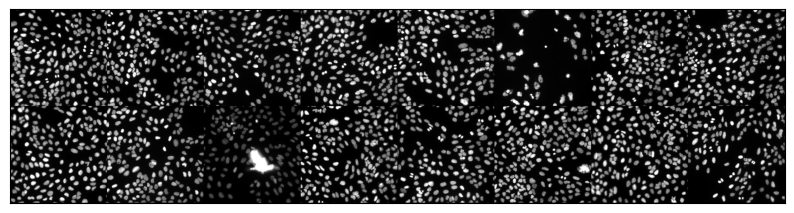

In [84]:
grid = make_grid(batch[:, :1, :, :], figsize=(14, 14))
show(grid)

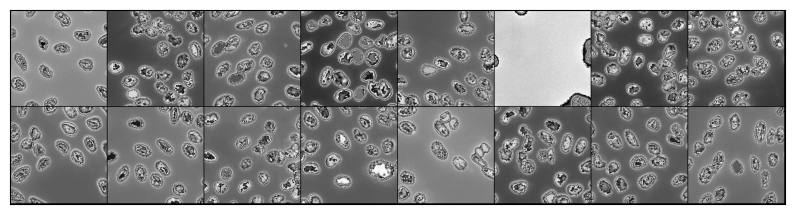

In [87]:
grid = make_grid(trans(batch)[:, :1, :, :], figsize=(14, 14))
show(grid)